In [135]:
casename = "ConservationCheck-2dSwim";

### Include Dyn3d and config files

In [136]:
using Pkg
Pkg.activate("../..")

using Revise
using Dyn3d
using Interact, Reactive
using Plots
pyplot()

Plots.PyPlotBackend()

In [137]:
# problem dimension
ndim = 2
# numerical params
tf = 8
dt = 1e-3
scheme = "Liska"
st = 5
tol = 1e-4
num_params = NumParams(tf, dt, scheme, st, tol)
# gravity
gravity = [0., 0., 0.]

# set up system config info
config_system = ConfigSystem(ndim, gravity, num_params)

# set up bodys
nbody = 3
config_body = ConfigBody(nbody, 4, [0. 0.; 1. 0.; 1. 1.0; 0. 1.0], 1.0)
config_bodys = fill(config_body, nbody)

# set up joints
njoint = nbody
config_joints = Vector{ConfigJoint}(undef,njoint)
gap = 0.1;

In [138]:
stiff = 0.05

0.05

In [139]:
dof₁ = Vector{Dof}(undef,3)
[dof₁[i] = Dof(i+2, "passive", 0., 0., Motions()) for i = 1:3]
config_joints[1] = ConfigJoint(njoint, "planar",
    [0.,0.,0.,0.6,2.0,0.], zeros(Float64,6), 0, dof₁, [0.0,0.0,0.0]);

In [140]:
motion₂ = Motions("oscillatory", [-1.0, 1.0/(2*π), -π/2])
dof₂ = Dof(3, "active", stiff, 0., motion₂)
config_joints[2] = ConfigJoint(njoint, "revolute",
   [0., 0., 0., 1.0+gap, 0., 0.],[0., 0., 0., -gap, 0., 0.],
   1, [dof₂], [0.]);

In [141]:
motion₃ = Motions("oscillatory", [-1.0, 1.0/(2*π), 0.0])
dof₃ = Dof(3, "active", stiff, 0., motion₃)
config_joints[3] = ConfigJoint(njoint, "revolute",
   [0., 0., 0., 1.0+gap, 0., 0.],[0., 0., 0., -gap, 0., 0.],
   2, [dof₃], [0.]);

### Build joint-body chain

In [142]:
bodys, joints, system = BuildChain(config_bodys, config_joints,
                                   config_system)
bd = BodyDyn(bodys, joints, system)

This is a 3 body-joint system, system is un-mounted from space

### Initialize system state

In [143]:
# init system
bd, soln = InitSystem!(bd)

# init soln structure
solns = (Soln)[]
push!(solns, soln)

# init VertsHistory struct
vs = []
push!(vs, VertsHistory(system.nbody, bd.bs));

### Set up HERKBody object

In [144]:
herk = HERKBody(system.num_params,HERKFuncM, HERKFuncGT, HERKFuncG,
                (HERKFuncf,HERKFuncgti), (UpdatePosition!,UpdateVelocity!),
                _conservationcheck=true)

Order-3 HERK time-marching function like object for Dyn3d


### Time Marching

#### Note that sometimes the solver can break due to singular matrix. Change between fixed step or not to solve the problem

In [145]:
λhist = []
bdhist = []
thist = [];

In [146]:
idx = 0
@time begin
while soln.t < tf
    # advance one step
    global soln, bd, dict = herk(soln, bd, _isfixedstep=true)

    # record soln and verts_i info
    push!(solns, soln)
    push!(vs, VertsHistory(system.nbody, bd.bs))
    push!(thist,deepcopy(soln.t)) 
    push!(λhist,deepcopy(soln.λ))
    push!(bdhist,deepcopy(bd))
        
    # print progress
    global idx += 1
    if mod(idx,500) == 1
        println("itr = $(idx), t = $(round(soln.t,digits=2)), dt = $(round(soln.dt,digits=4))")
    end
end
println("itr = $(idx), t = $(round(soln.t,digits=2)), dt = $(round(soln.dt,digits=4)) \n")
end

itr = 1, t = 0.0, dt = 0.001
itr = 501, t = 0.5, dt = 0.001
itr = 1001, t = 1.0, dt = 0.001
itr = 1501, t = 1.5, dt = 0.001
itr = 2001, t = 2.0, dt = 0.001
itr = 2501, t = 2.5, dt = 0.001
itr = 3001, t = 3.0, dt = 0.001
itr = 3501, t = 3.5, dt = 0.001
itr = 4001, t = 4.0, dt = 0.001
itr = 4501, t = 4.5, dt = 0.001
itr = 5001, t = 5.0, dt = 0.001
itr = 5501, t = 5.5, dt = 0.001
itr = 6001, t = 6.0, dt = 0.001
itr = 6501, t = 6.5, dt = 0.001
itr = 7001, t = 7.0, dt = 0.001
itr = 7501, t = 7.5, dt = 0.001
itr = 8000, t = 8.0, dt = 0.001 

  9.375996 seconds (15.64 M allocations: 2.932 GiB, 28.15% gc time)


In [147]:
# bodys, joints, system = bd.bs, bd.js, bd.sys

# using Interpolations

# # create regular time grid and acquire solutions on it
# qJ_regs = Float64[]
# t_reg = range(0,stop=solns[end].t,length=length(solns))
# for i = 1:system.ndof
#     t_temp = ([solns[k].t for k = 1:length(solns)],)
#     qJ_temp = [solns[k].qJ[i] for k = 1:length(solns)]   
#     qJ_reg = interpolate(t_temp, qJ_temp, Gridded(Linear()))(t_reg)
#     append!(qJ_regs, qJ_reg)
# end
# qJ_regs = reshape(qJ_regs,(length(solns), system.ndof))

# # get verts info based on this regular grid solution
# vs_reg = []
# bodys_reg = deepcopy(bodys)
# joints_reg = deepcopy(joints)
# system_reg = deepcopy(system)
# for i = 1:length(solns)
#     bodys_reg, joints_reg, system_reg = UpdatePosition!(bodys_reg, joints_reg, system_reg, solns[i].qJ)
#     push!(vs_reg, VertsHistory(system.nbody, bodys_reg))
# end

In [148]:
# # plot direction
# v = @isdefined(plot_dir) ? plot_dir : system.ndim==2 ? (1,2) : (1,2,3)

# if system.ndim == 2
#     # push the verts of all body in the same time into a tuple
#     vs_total = []
#     for i = 1:length(t_reg)
#         vs_tmp = []
#         for k = 1:system.nbody
#             push!(vs_tmp,[vs_reg[i][k,:,v[1]],vs_reg[i][k,:,v[2]]])
#         end
#         push!(vs_total,vs_tmp)
#     end
# elseif system.ndim == 3
#     h = [1:bodys[1].nverts;1]
#     # push the verts of all body in the same time into a tuple
#     vs_total = []
#     for i = 1:length(t_reg)
#         vs_tmp = []
#         for k = 1:system.nbody
#             push!(vs_tmp,[vs_reg[i][k,h,v[1]],vs_reg[i][k,h,v[2]],vs_reg[i][k,h,v[3]]])
#         end
#         push!(vs_total,vs_tmp)
#     end       
# end

In [149]:
# # Total number of seconds of this gif
# gif_time = 8;

In [150]:
# freq = round(Int,idx/30/gif_time)
# camera_view = (45,45)

# if system.ndim == 2
#     anim = @animate for i = 1:freq:length(t_reg)
#         p = plot()        
#         for j in 1:system.nbody
#             plot!(vs_total[i][j][1],vs_total[i][j][2], linewidth=3)            
#         end    
#         plot!(xlims=(0,6), ylims=(0,3), aspect_ratio=:equal)        
#     end        
# elseif system.ndim == 3 
#     anim = @animate for i = 1:freq:length(t_reg)
#         h = [1:bodys[1].nverts;1]
#         p = plot()
#         for j in 2:system.nbody
#             plot!(vs_total[i][j][1],vs_total[i][j][2],vs_total[i][j][3], linewidth=3)
#         end    
#         plot!(xlims=(-2,2), ylims=(-2,2), zlims=(-2,2), aspect_ratio=:equal, camera = camera_view)
#     end    
# end
# nothing
# gif(anim, casename*".gif", fps = 30)

## Momentum Conservation

#### In the swim case, the only source of momentum is angular momentum provided by the active dof, so there's no x and y linear momentum. Also gravity is 0 in this example. The overall system linear momentum is very much near 0.

In [151]:
n = length(solns)-1
t = [solns[i].t for i=3:n+1]

# y_n+1 = y_n + RK(y'_n)
xmkin = [dict["mkin"][i][1].-dict["mkin"][i-1][1] for i=2:n]
xmlag = [dict["mlag"][i][1] for i=2:n]
xmgra = [dict["mgra"][i][1] for i=2:n]
xmsum = xmkin + xmlag + xmgra

ymkin = [dict["mkin"][i][2].-dict["mkin"][i-1][2] for i=2:n]
ymlag = [dict["mlag"][i][2] for i=2:n]
ymgra = [dict["mgra"][i][2] for i=2:n]
ymsum = ymkin + ymlag + ymgra;

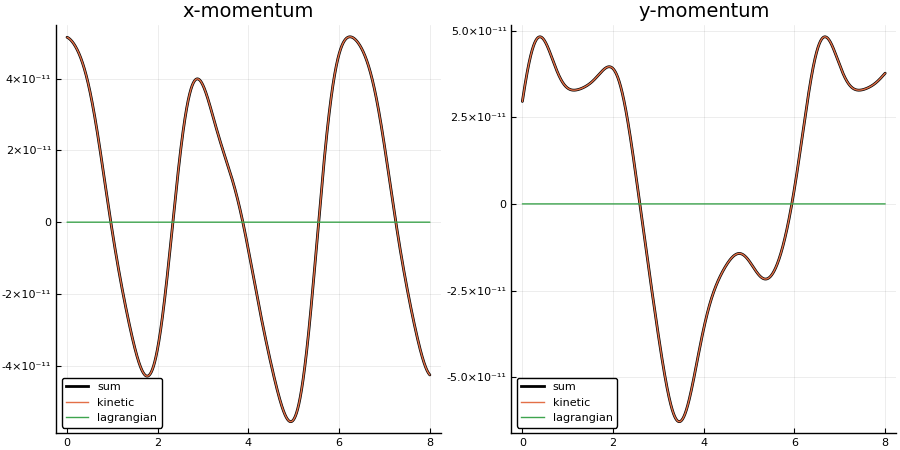

In [152]:
p1 = plot(t,xmsum,title="x-momentum",label="sum",linewidth=2,color="black")
plot!(p1,t,xmkin,label="kinetic")
plot!(p1,t,xmlag,label="lagrangian")
# plot!(p1,t,xmgra,label="gravity")

p2 = plot(t,ymsum,title="y-momentum",label="sum",linewidth=2,color="black")
plot!(p2,t,ymkin,label="kinetic")
plot!(p2,t,ymlag,label="lagrangian")
# plot!(p2,t,ymgra,label="gravity")

plot(p1,p2,size=(900,450))

In [153]:
bd.js[2].joint_dof[1].stiff

0.05

In [154]:
bd.js[2].joint_dof[1].dof_id

3

## Energy Conservation 

In [155]:
n = length(solns)-1
t = [solns[i].t for i=3:n+1];

# y_n+1 = y_n + RK(y'_n)
ekin = [dict["ekin"][i]-dict["ekin"][i-1] for i=2:n]
espr = [dict["espr"][i]-dict["espr"][i-1] for i=2:n]
egra = [dict["egra"][i]-dict["egra"][i-1] for i=2:n]
edam = dict["edam"][2:end]
elag = dict["elag"][2:end]
esum = ekin + espr + egra + edam + elag;

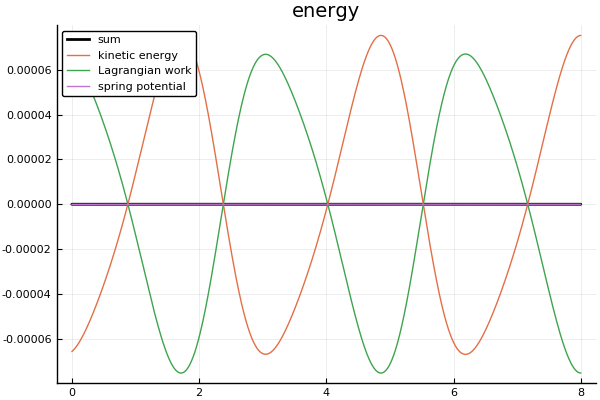

In [156]:
plot(t,esum,title="energy",label="sum",linewidth=2,color="black")
plot!(t,ekin,label="kinetic energy")
plot!(t,elag,label="Lagrangian work")
plot!(t,espr,label="spring potential")
# plot!(t,egra,label="gravity potential")
# plot!(t,edam,label="damping")

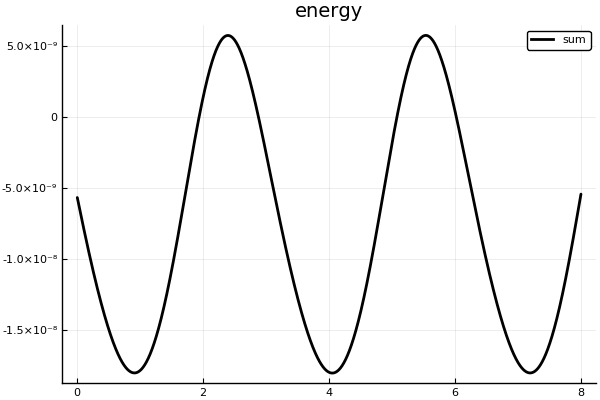

In [157]:
plot(t,esum,title="energy",label="sum",linewidth=2,color="black")

## Varying timestep and compare error in energy conservation

In [56]:
# dt = 1.6e-2
t_1 = t
esum_1 = esum;

In [86]:
# dt = 8e-3
t_2 = t
esum_2 = esum;

In [110]:
# dt = 4e-3
t_3 = t
esum_3 = esum;

In [134]:
# dt = 2e-3
t_4 = t
esum_4 = esum;

In [158]:
# dt = 1e-3
t_5 = t
esum_5 = esum;

#### Energy is around 2nd order accurate

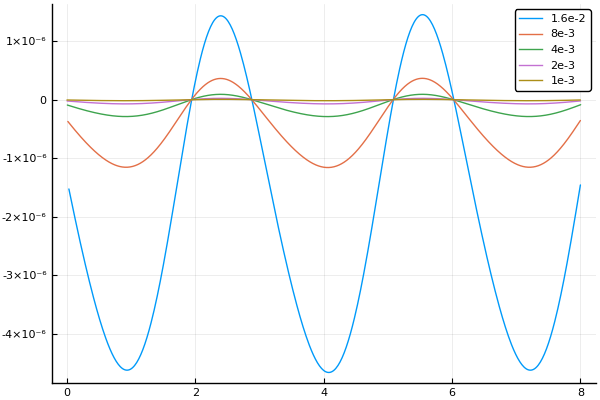

In [159]:
plot(t_1,esum_1,label="1.6e-2")
plot!(t_2,esum_2,label="8e-3")
plot!(t_3,esum_3,label="4e-3")
plot!(t_4,esum_4,label="2e-3")
plot!(t_5,esum_5,label="1e-3")

In [160]:
# choose t=4 to compare the errors
println(esum_1[250]/esum_2[500])
println(esum_2[500]/esum_3[1000])
println(esum_3[1000]/esum_4[2000])
println(esum_4[2000]/esum_5[4000])

4.014694936403303
4.007035361150632
4.003438931262178
4.001699687635541
